In [49]:
import matplotlib.pyplot as plt
import numpy as np

In [50]:
def extract_polynomial_features(X, k):
    features = [np.ones_like(X)]
    
    for degree in range(1, k):
        features.append(np.power(X, degree))
    
    # Concatenate all the features into a single array along axis=1 (column-wise concatenation)
    return np.concatenate(features, axis=1)

In [ ]:
# Find best w
def hat_w(X, y, k):
    phi = extract_polynomial_features(X, k)
    w = np.linalg.solve(phi.T @ phi, phi.T @ y)
    return w

In [ ]:
# 
def predict_polynomial(X, w, k):
    phi = extract_polynomial_features(X, k)
    return phi @ w

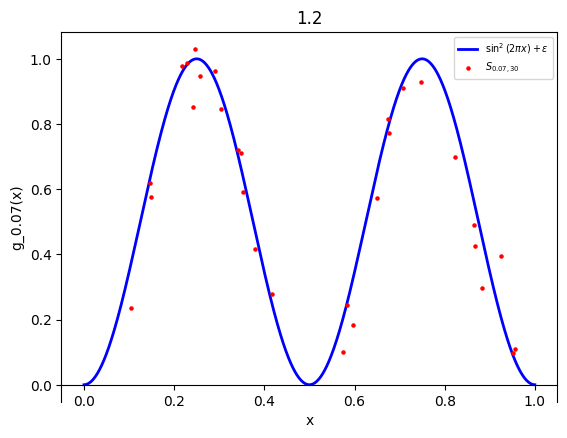

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Function g_sigma(x) with sigma = 0.07
def g_sigma(x, sigma=0.07):
    
    sin_squared = np.sin(2 * np.pi * x)**2
    epsilon = np.random.normal(0, sigma, size=x.shape)
    
    return sin_squared + epsilon

# Generate values and get y prediction
x_samples = np.random.uniform(0, 1, 30)
y_samples = g_sigma(x_samples, sigma=0.07)

# Prepare plotting
x_fine = np.linspace(0, 1, 1000)
y_fine = np.sin(2 * np.pi * x_fine)**2

# Plot function
plt.plot(x_fine, y_fine, label=r'$\sin^2(2\pi x) + \epsilon$', color='blue', lw=2)

plt.scatter(x_samples, y_samples, color='red', label=r'$S_{0.07,30}$', zorder=5, s=5)

plt.xlabel('x')
plt.ylabel('g_0.07(x)')
plt.title('1.2')
plt.legend(fontsize='x-small')
ax = plt.gca()
ax.spines['bottom'].set_position('zero')
plt.show()

[[0.33005949]
 [0.25848383]]
[[ -0.41715616]
 [ 13.69136308]
 [-58.81884838]
 [ 92.43009207]
 [-47.40763789]]
[[ 1.83914391e-01]
 [-1.02614776e+01]
 [ 1.82076880e+02]
 [-9.01257566e+02]
 [ 2.62286443e+03]
 [-7.09971124e+03]
 [ 1.56542411e+04]
 [-2.07737318e+04]
 [ 1.40967981e+04]
 [-3.77137096e+03]]
[[ 4.89110109e-03]
 [ 4.37375313e+00]
 [-1.78163546e+02]
 [ 2.74593409e+03]
 [-1.38520100e+04]
 [ 1.58250077e+04]
 [ 9.43329688e+04]
 [-3.87254780e+05]
 [ 5.11158281e+05]
 [ 1.15407539e+05]
 [-1.16437491e+06]
 [ 1.45974131e+06]
 [-8.08118455e+05]
 [ 1.74563390e+05]]
[[ 1.83792737e-01]
 [-1.32784377e+01]
 [ 4.06603487e+02]
 [-6.32424462e+03]
 [ 6.14440245e+04]
 [-3.36086945e+05]
 [ 9.97634818e+05]
 [-1.37182927e+06]
 [-1.68488424e+05]
 [ 2.93136110e+06]
 [-2.48104008e+06]
 [-1.57057948e+06]
 [ 2.55547624e+06]
 [ 5.19172889e+05]
 [-8.41714626e+05]
 [-1.71480649e+06]
 [ 2.01834253e+06]
 [-5.92957097e+05]]


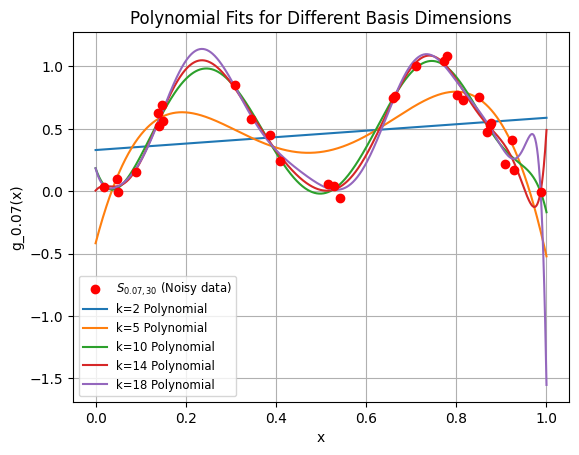

In [59]:
# Generate 30 random samples from the interval [0, 1]
X_samples = np.random.uniform(0, 1, 30).reshape(-1, 1)

# Compute the corresponding y values for the noisy function g_0.07(x)
y_samples = g_sigma(X_samples, sigma=0.07)

# Create a finer range of x values to plot the fitted curves
X_fine = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plot the noisy data points
plt.scatter(X_samples, y_samples, color='red', label=r'$S_{0.07,30}$ (Noisy data)', zorder=5)

# Fit and plot polynomial curves for k = 2, 5, 10, 14, 18
for k in [2, 5, 10, 14, 18]:
    # Fit the polynomial to the data
    w = hat_w(X_samples, y_samples, k)
    # Predict the values using the fitted polynomial model
    y_fitted = predict_polynomial(X_fine, w, k)
    # Plot the fitted curve
    plt.plot(X_fine, y_fitted, label=f'k={k} Polynomial')

# Add labels and title
plt.xlabel('x')
plt.ylabel('g_0.07(x)')
plt.title('Polynomial Fits for Different Basis Dimensions')
plt.legend(fontsize = 'small' )

# Show the plot
plt.grid(True)
plt.show()